In [180]:
import tensorflow

print(tensorflow.__version__)

2.6.0


In [181]:
!pip install konlpy

# 데이터 로드 및 전처리

In [182]:
import re
import pandas as pd
import tensorflow as tf
import numpy as np
from konlpy.tag import Okt
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


In [183]:
# konlpy의 형태소 분석기 Okt 사용
okt = Okt()

def preprocess_sentence(sentence):
    # 1. 한글과 공백을 제외한 문자 모두 제거
    sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', sentence)
    
    # 2. 한국어 형태소 분석
    sentence = ' '.join(okt.morphs(sentence, stem=True))
    
    # 3. 불용어 제거 (필요에 따라 불용어 리스트를 확장할 수 있습니다)
    stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']
    sentence = ' '.join(word for word in sentence.split() if word not in stopwords)
    
    # 4. 공백 정리
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    
    return sentence

In [184]:
def load_conversations():
    # ChatbotData.csv 파일 로드
    data = pd.read_csv('/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv')
    questions = data['Q'].tolist()
    answers = data['A'].tolist()
    
    inputs, outputs = [], []
    for question, answer in zip(questions, answers):
        inputs.append(preprocess_sentence(question))
        outputs.append(preprocess_sentence(answer))
    
    return inputs, outputs

# 데이터 로드 및 전처리
questions, answers = load_conversations()


In [185]:
# 문장 길이 분포 확인
lengths = [len(sentence.split()) for sentence in questions + answers]
print('최대 문장 길이 :', max(lengths))
print('평균 문장 길이 :', np.mean(lengths))
print('최소 문장 길이 :', min(lengths))


최대 문장 길이 : 25
평균 문장 길이 : 4.362302292142434
최소 문장 길이 : 0


In [186]:
# 문장 길이 기준으로 필터링 (예: 최대 길이 40)
MAX_LENGTH = 40

def filter_max_length(inputs, outputs):
    filtered_inputs, filtered_outputs = [], []
    for inp, out in zip(inputs, outputs):
        if len(inp.split()) <= MAX_LENGTH and len(out.split()) <= MAX_LENGTH:
            filtered_inputs.append(inp)
            filtered_outputs.append(out)
    return filtered_inputs, filtered_outputs

questions, answers = filter_max_length(questions, answers)

print('전처리 후 질문-답변 쌍의 개수 :', len(questions))

전처리 후 질문-답변 쌍의 개수 : 11823


# SubwordTextEncoder 사용하기

In [187]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2
MAX_LENGTH = 40

def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)

BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 모델 구성

In [188]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [189]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output


In [190]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key) 
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value =self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

### 패딩, 인코딩, 디코딩

In [191]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [192]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [193]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [194]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [195]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [196]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 모델 학습

In [197]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [198]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    12131840    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [199]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [200]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

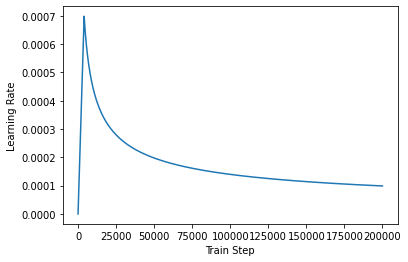

In [201]:
sample_learning_rate = CustomSchedule(d_model=512)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [202]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


class LearningCurveMonitor(tf.keras.callbacks.Callback):
    def __init__(self, patience=3):
        super(LearningCurveMonitor, self).__init__()
        self.patience = patience
        self.best_loss = np.Inf
        self.wait = 0
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        self.losses.append(current_loss)
        
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print(f'\nTraining stopped at epoch {epoch+1} due to no improvement in loss.')
        
lc_monitor = LearningCurveMonitor(patience=3)


def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# L2 정규화 추가
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        layer.add_loss(lambda: tf.keras.regularizers.l2(1e-4)(layer.kernel))

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [203]:
EPOCHS = 20

model.fit(dataset, epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE,
           callbacks=[lc_monitor])

Epoch 1/20
185/185 [==============================] - 46s 172ms/step - loss: 1.1863 - accuracy: 0.0222
Epoch 2/20
185/185 [==============================] - 33s 176ms/step - loss: 0.9433 - accuracy: 0.0260
Epoch 3/20
185/185 [==============================] - 33s 180ms/step - loss: 0.8295 - accuracy: 0.0308
Epoch 4/20
185/185 [==============================] - 33s 181ms/step - loss: 0.7768 - accuracy: 0.0354
Epoch 5/20
185/185 [==============================] - 33s 178ms/step - loss: 0.7359 - accuracy: 0.0393
Epoch 6/20
185/185 [==============================] - 33s 178ms/step - loss: 0.6918 - accuracy: 0.0438
Epoch 7/20
185/185 [==============================] - 33s 178ms/step - loss: 0.6486 - accuracy: 0.0476
Epoch 8/20
185/185 [==============================] - 33s 178ms/step - loss: 0.6083 - accuracy: 0.0514
Epoch 9/20
185/185 [==============================] - 33s 178ms/step - loss: 0.5708 - accuracy: 0.0552
Epoch 10/20
185/185 [==============================] - 33s 178ms/step - l

# 챗봇 테스트

In [204]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [205]:
def sentence_generation(sentence):
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    output_sequence = tf.squeeze(output_sequence, axis=0)
    predicted_sentence = tokenizer.decode(
        [i for i in output_sequence if i < tokenizer.vocab_size])

    print('입력: {}'.format(sentence))
    print('출력: {}'.format(predicted_sentence))

    return predicted_sentence

# 모델 평가

In [206]:
print(sentence_generation("주말인데 뭐할까?"))
print(sentence_generation("날씨가 너무 더워서 힘들어"))
print(sentence_generation("피곤해서 못일어 나겠어"))

입력: [[7265  469  113  555 7266]]
출력: 친구 사귀다 수 있다 거 예요
친구 사귀다 수 있다 거 예요
입력: [[7265  448   18 1302   69 7266]]
출력: 따뜻하다
따뜻하다
입력: [[7265  738   53  109  296 7266]]
출력: 충전 곳 로 곳 로 생각 하고 있다
충전 곳 로 곳 로 생각 하고 있다


### 회고와 정리

- 트랜스포머 
    - 문장을 이해하고 새로운 문장을 만들어내는 강력한 모델 (인코더, 디코더)


- 인코더 
    - 우리가 입력한 문장을 분석하는 역할 
    - 중요한 것은 문장 속 단어들이 서로 어떤 관계가 있는지를 파악하는 건데, 이를 위해 셀프 어텐션이라는 기술을 사용


- 어텐션의 기본 개념: 쿼리, 키, 밸류
    - 쿼리 :현재 단어가 다른 단어와의 관계를 어떻게 찾을지 결정하는 기준
    - 키 :모든 단어들이 자신을 다른 단어와 비교할 수 있도록 제공하는 고유 정보
    - 벨류: 실제로 참조할 정보, 즉 단어의 의미

- 스케일드 닷 프로덕트 어텐션

    - 1, 쿼리와 키의 내적(Dot Product) 계산
        - 각 쿼리와 모든 키를 내적 연산을 통해 비교 
        - 내적은 두 벡터 사이의 유사도를 나타내는 연산으로, 두 벡터가 얼마나 비슷한지 알 수 있음 
        - 이 결과로 각 단어 쌍의 유사도를 계산
    
    - 2. 스케일링(Scaling) 
        - 내적 결과에 특정 값을 나눠줘서 스케일링, 
        - 보통 이 값은 키 벡터의 차원 수의 제곱근 
        - 이렇게 하면 큰 값들로 인해 발생할 수 있는 불안정한 학습을 방지
    
    - 3. 소프트맥스(Softmax) 적용
        - 스케일링된 유사도 값들에 소프트맥스 함수를 적용 
        - 이 값들이 0과 1 사이의 확률 분포로 변환
        - 이 확률이 바로 각 단어가 얼마나 관련이 있는지에 대한 가중치로 사용
    
    - 4. 밸류와의 곱셈
        - 각 밸류에 이 확률 가중치를 곱해서 가중합을 계산. 
        - 결과가 바로 어텐션 값이며 이 값은 쿼리에 따라 단어들의 중요도를 반영한 결과


- 셀프 어텐션
    - 셀프 어텐션은 각 단어가 문장 내의 다른 단어들과 얼마나 관련이 있는지를 계산. 
 

- 멀티헤드 어텐션 
    - 여러 개의 셀프 어텐션을 동시에 병렬로 수행
    - 여러개의 어텐션 값을 다시 합쳐(concatenate) 더 다양한 단어 간의 관계를 파악

- 피드포워드 신경망
    - 정보를 처리해서 더 정제된 의미를 생성 
    - 이 과정은 단어 간의 관계를 더 명확하게 하고, 문장의 의미를 잘 추출하는 데 도움

- 디코더
    - 디코더는 인코더가 분석한 정보를 바탕으로 새로운 문장을 만들어내는 역할 
    - 이 과정은 인코더보다 조금 더 복잡하며, 세 가지 중요한 서브레이어(Sub-Layer)가 존재
    
- 디코더 셀프 어텐션
    - 디코더는 단어를 하나씩 만들어내면서, 이미 생성된 단어들과의 관계를 계속 고려 
    - 예를 들어, "The cat"이라고 이미 생성했다면, 다음 단어로 자연스럽게 "climbed"가 나와야 한다는 것을 파악

- 인코더-디코더 어텐션
    - 인코더에서 전달된 정보와 디코더가 만든 단어들을 비교해서, 더 정확한 단어를 선택 
    - 마치 번역가가 원문을 참고해서 올바른 번역을 하는 것과 비슷
    - 셀프 어텐션이 아님

- 피드포워드 신경망(디코더 부분)
    - 디코더가 만든 단어들을 정리하고, 최종 결과물을 만들어내는 데 도움
    
- 포지셔널 인코딩
    - 트랜스포머는 문장을 단어 하나하나 차례대로 읽는 것이 아니라, 문장 전체를 한꺼번에 처리
    - 단어들이 문장에서 어떤 순서로 나왔는지를 인식하기 어려움
    - 이를 해결하기 위해 포지셔널 인코딩(Positional Encoding)사용. 
    - 이건 단어들에 위치 정보를 더해주는 작은 비밀 코드 같은 거야. 
    - 이 코드 덕분에 트랜스포머는 단어의 순서가 다른 문장들을 구별
    
- 마스킹
   
   - 트랜스포머에서는 문장을 처리할 때 불필요한 부분을 무시하고 필요한 정보에만 집중하도록 마스킹이라는 기술을 사용 (패딩, 룩어헤드)
    
- 패딩 마스킹
   
   - 패딩 마스킹은 문장에 의미 없는 단어(보통 숫자 0으로 표시됨)가 있을 때, 그 부분을 무시

- 룩어헤드 마스킹 
   
    - 룩 어헤드 마스킹은 디코더가 미래에 나올 단어를 미리 보지 않도록 막음. 
    - 이렇게 해야 디코더가 앞에서 만들어진 단어들만 참고해서 다음 단어를 예측 
    - 이는 RNN과 다르게, 트랜스포머는 문장 전체를 한 번에 입력받기 때문에 필요해진 장치




### 느낀점

- 한국어로 챗봇을 만드는 것은 전처리도 더 다르게 했고, 일반적으로 영어 해석보다 더 어려운 것으로 알고 있어서, 성능을 높이기 위해서 앞에서 배웠던 것들을 추가했다.
- L2 정규화, 조기종료, 하이퍼 파라미터 조정과 시도 횟수를 증가 시켰다.
- 조기종료를 사용할때 WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy와 같이  'val_loss'를 모니터링하려고 하지만, 현재 학습 과정에서 검증 손실을 계산하고 있지 않기 때문에 발생하는 경고메세지가 출력되었다.
- 아래의 코드는 기존의 코드이며, 학습 곡선을 모니터링하고 수동으로 학습을 중단하는 방법을 구현하기 위해,커스텀 콜백을 사용하였다. 이 콜백은 각 에폭 후에 손실을 확인하고, 손실이 더 이상 감소하지 않거나 증가하기 시작할 때 학습을 중단한다.

In [207]:
# 기존의 코드 

# # L2 정규화 추가
# for layer in model.layers:
#     if isinstance(layer, tf.keras.layers.Dense):
#         layer.add_loss(lambda: tf.keras.regularizers.l2(1e-4)(layer.kernel))

# model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# EPOCHS = 20  # 증가
# BATCH_SIZE = 32  # 배치 크기 조정 (필요에 따라)

# # 콜백 추가
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

# model.fit(dataset, epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE,
#           callbacks=[early_stopping, model_checkpoint])


### 기존의 코드 결과물
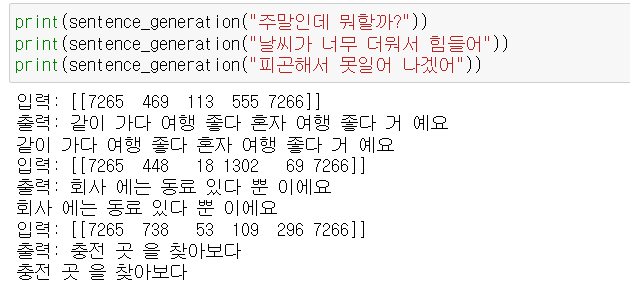